**Deep Learning AA 2022/2023**
** **
Teachers:\
Fabrizio Silvestri (fsilvestri@diag.uniroma1.it)\
Antonio Purificato (antonio.purificato@uniroma1.it)\
Farooq Wani (wani@diag.uniroma1.it)\
Maria Sofia Bucarelli (bucarelli@diag.uniroma1.it) \

**Are Transformers used only in Natural Language Processing?**

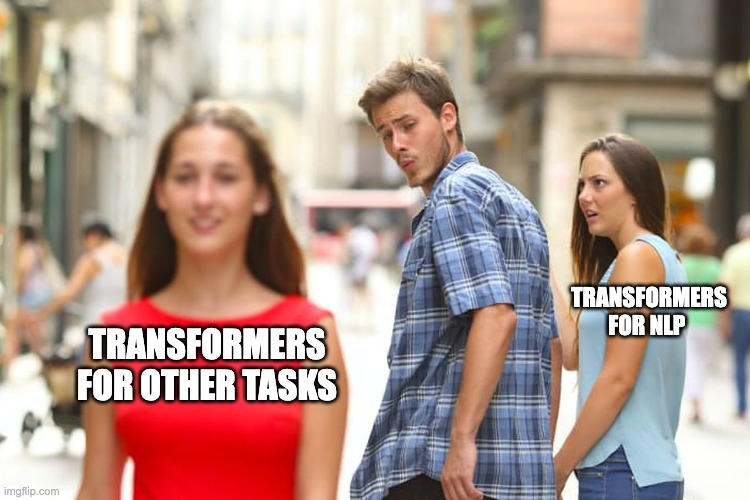


The _Informer_ model ([Zhou, Haoyi, et al., 2021](https://arxiv.org/abs/2012.07436)), AAAI21 best paper is [available](https://huggingface.co/docs/transformers/main/en/model_doc/informer) in 🤗 Transformers. The Informer model for the **multivariate** can be applied to the probabilistic forecasting task, i.e., predicting the distribution of a future **vector** of time-series target values.

**Informer architecture**



* _Encoder_: It is designed is to extract the robust long-range dependencies of the long sequential inputs. It has extra combinations of value *V* as a result of the ProbSparse self-attention mechanism. The distilling operation is used to score the superior ones with dominating features and build a concentrated self-attention feature map in the next layer.

* _Decoder_: It is the standard decoder structure that is illustrated in [Attention is All You Need](https://arxiv.org/abs/1706.03762). It includes a stack of two identical multi-head attention layers. But, the generative inference is proposed to ease the speed plunge in long prediction.

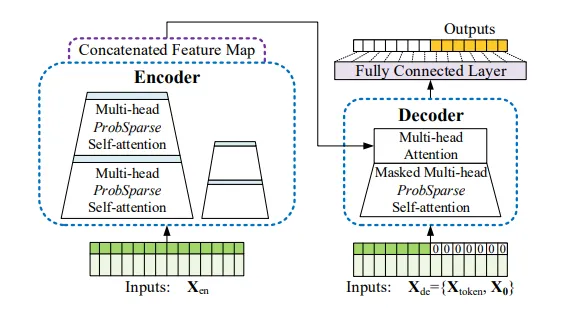

# Download and import

In [ ]:
%%capture
! pip install datasets==2.11.0 loralib sentencepiece
! pip install transformers accelerate bitsandbytes
! pip install peft gradio appdirs
! pip install evaluate
! pip install wandb
!pip install -q protobuf --upgrade
! pip install -q "gluonts[torch]" ujson tqdm

In [ ]:
from transformers import GraphormerForGraphClassification

In [ ]:
from typing import *
import torch
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import wandb

from pandas.core.arrays.period import period_array
from transformers import (LlamaTokenizer, LlamaForCausalLM, GenerationConfig,
    InformerConfig, InformerForPrediction, PretrainedConfig)
from peft import PeftModel
import matplotlib.dates as mdates
from functools import lru_cache, partial
from datasets import load_dataset
from sklearn.metrics import mean_absolute_error
from accelerate import Accelerator

from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator
import networkx as nx
from transformers import GraphormerForGraphClassification

from gluonts.time_feature import get_lags_for_frequency
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.time_feature import TimeFeature
from gluonts.transform.sampler import InstanceSampler
from gluonts.dataset.field_names import FieldName
from gluonts.itertools import Cached, Cyclic
from gluonts.time_feature import get_seasonality
from gluonts.dataset.loader import as_stacked_batches
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)


/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /usr/local/lib/python3.10/dist-packages/transformers/models/graphormer/algos_graphormer.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
wandb.login(key = '88987d90526e97d3144c1c3c7ff85ae9b3ea37ad')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Dataset loading

We use the `traffic_hourly` dataset, which is available on the [Hugging Face Hub](https://huggingface.co/datasets/monash_tsf). It contains 862 hourly time series showing the road occupancy rates in the range $[0, 1]$ on the San Francisco Bay area freeways from 2015 to 2016.

In [ ]:
%%capture
dataset = load_dataset("monash_tsf", "traffic_hourly")

This example has `prediction_length=48` (48 hours, or 2 days) additional values compared to the training example.

In [ ]:
train_example = dataset["train"][0]
validation_example = dataset["validation"][0]

In [ ]:
freq = "1H"
prediction_length = 48
num_of_samples = 150

assert len(train_example["target"]) + prediction_length == len(
    dataset["validation"][0]["target"]
)

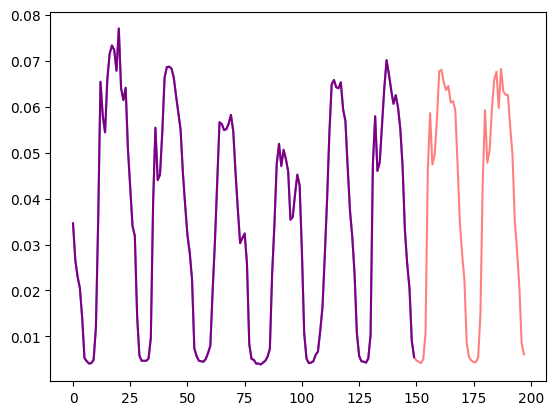

In [ ]:
figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    validation_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

The first thing is to convert the `start` feature of each time series to a pandas `Period` index using the data's `freq`:

In [ ]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [ ]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

Now, let's convert the dataset into a multivariate time series using the `MultivariateGrouper` from GluonTS. This grouper will convert the individual 1-dimensional time series into a single 2D matrix.

In [ ]:
num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

# Define the model

Next, let's instantiate a model. The model will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/main/en/model_doc/informer#transformers.InformerConfig).

We specify a couple of additional parameters to the model:
- `prediction_length`: this is the horizon that the decoder of the Informer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if no `context_length` is specified;
- `lags` for a given frequency: these specify an efficient "look back" mechanism, where we concatenate values from the past to the current values as additional features, e.g. for a `Daily` frequency we might consider a look back of `[1, 7, 30, ...]` or for `Minute` data we might consider `[1, 30, 60, 60*24, ...]` etc.;
- the number of time features: in our case, this will be `5` as we'll add `HourOfDay`, `DayOfWeek`, ..., and `Age` features (see below).

In this case, there are four additional features, namely "hour of day", "day of week", "day of month" and "day of year". This means that for each time step, we'll add these features as a scalar values. For example, consider the timestamp `2015-01-01 01:00:01`. The four additional features will be:

In [ ]:
time_features = time_features_from_frequency_str(freq)
lags_sequence = get_lags_for_frequency(freq)

timestamp = pd.Period("2015-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'hour_of_day': array([-0.45652174]), 'day_of_week': array([0.]), 'day_of_month': array([-0.5]), 'day_of_year': array([-0.5])}


In [ ]:
config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,

    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

# Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

In [ ]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

# Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset.

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys for the respective windows. This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively. The same happens for any keys in the `time_series_fields` argument:

In [ ]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

# Dataloaders creation

In [ ]:
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [ ]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [ ]:
train_batch_size = 256
test_batch_size = 32

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=train_batch_size,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=test_batch_size,
)

Let's check the first batch:

In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 264, 5]) torch.FloatTensor
past_values torch.Size([256, 264, 862]) torch.FloatTensor
past_observed_mask torch.Size([256, 264, 862]) torch.FloatTensor
future_time_features torch.Size([256, 48, 5]) torch.FloatTensor
future_values torch.Size([256, 48, 862]) torch.FloatTensor
future_observed_mask torch.Size([256, 48, 862]) torch.FloatTensor


As can be seen, we don't feed `input_ids` and `attention_mask` to the encoder (as would be the case for NLP models), but rather `past_values`, along with `past_observed_mask`, `past_time_features` and `static_real_features`.

The decoder inputs consist of `future_values`, `future_observed_mask` and `future_time_features`. The `future_values` can be seen as the equivalent of `decoder_input_ids` in NLP.

We refer to the [docs](https://huggingface.co/docs/transformers/main/en/model_doc/informer#transformers.InformerForPrediction.forward.past_values) for a detailed explanation for each of them.

# Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

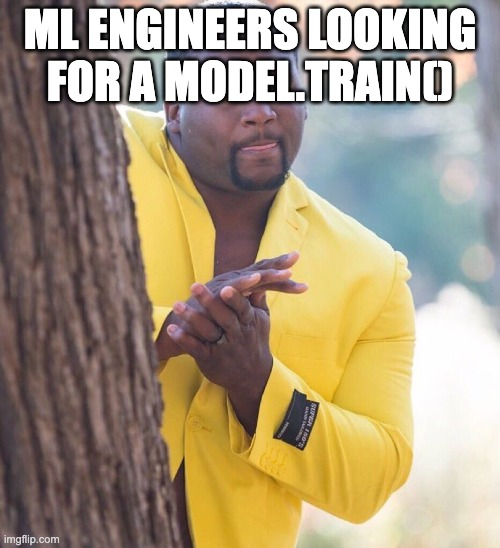

In [ ]:
epochs = 2
learning_rate = 6e-4
loss_history = []

accelerator = Accelerator()

model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

In [ ]:
wandb.init(project= "Transformers for time series prediction",
      name= "First run",
      config={
      "learning_rate": learning_rate,
      "dataset": "traffic hourly",
      "epochs": epochs,
      "train batch size" : train_batch_size,
      "test batch size" : test_batch_size
      })

wandb: Currently logged in as: antoniopurificato. Use `wandb login --relogin` to force relogin


In [ ]:
model.train()
for epoch in tqdm(range(epochs)):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        wandb.log({'training loss' : loss.item()})

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

  0%|          | 0/2 [00:00<?, ?it/s]

-1068.7215576171875
-2162.5908203125


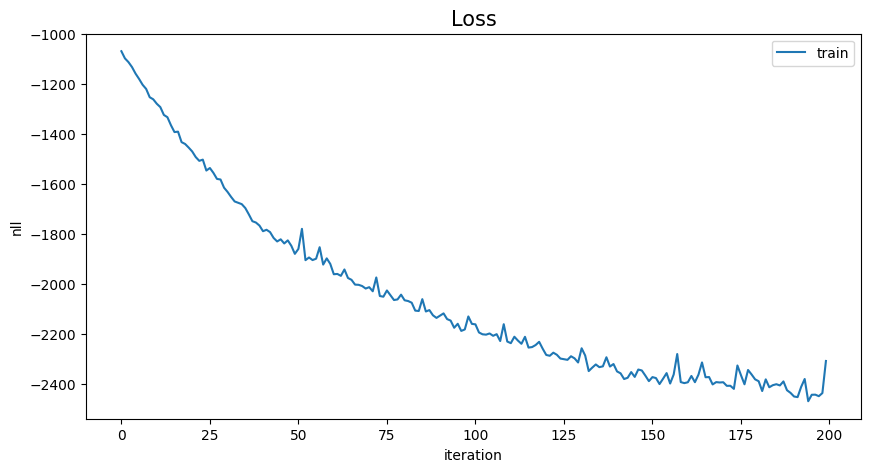

In [ ]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

In [ ]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts = np.vstack(forecasts_)

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [ ]:
forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mean_absolute_scaled_error(
        np.array(ground_truth),
        forecast_median[item_id],
        np.array(training_data),
    )
    mase_metrics.append(mase)

In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.564290811527242


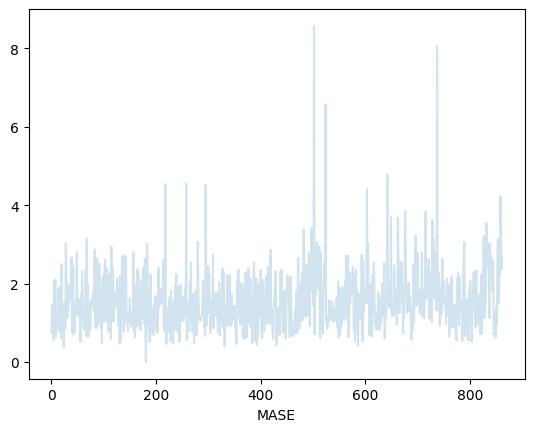

In [ ]:
plt.plot(mase_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.show()
wandb.log({"chart" : wandb.Histogram(mase_metrics)})

In [ ]:
wandb.finish()

training loss,██▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂
training loss,-2309.32593


In [ ]:
def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][mv_index, -2 * prediction_length :],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()

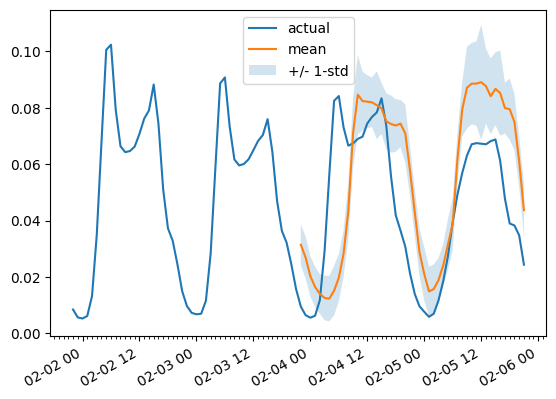

In [ ]:
plot(0, 300)